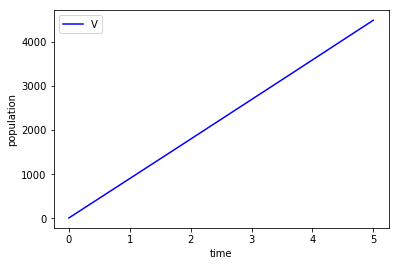

In [6]:
# odeint performed on SIR model
import numpy as np
import scipy.integrate as integrate 
import matplotlib.pyplot as plt

# defining the SIR model as a function
def model(z,t):
    # constants 
    s=110  #speed
    f=1    #flow
    d=100  #length of highway (one part)
    l=4    #Number of lanes of stretch of highway
    j=135    #jam density
    #Variables
    V=z[0]
    # defining the differential equations 
    dVdt = 1000-s*(1-V/(d*l*j))
    # returning the system as dzdt
    return dVdt

# initial conditions [V_0]
z0 = [10]

# time points from (first argument,second argument) with 'third argument' number of points
t = np.linspace(0,5,1000)

# solve system of ODEs with odeint
z = integrate.odeint(model,z0,t)

# plot results
plt.plot(t,z[:,0],'b-',label='V')
plt.ylabel('population')
plt.xlabel('time')
plt.legend(loc='best')
plt.show() 

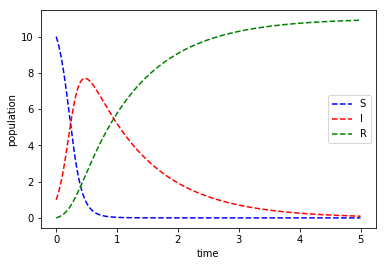

In [78]:
# runge-kuta performed on SIR model
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.RK45.html
import numpy as np
import scipy.integrate as integrate 
import matplotlib.pyplot as plt

# defining the SIR model as a function. Notice that arguments are (t,z) this time and not (z,t)!!
def model(t,z):
    # constants 
    a = 1
    b = 1
    # variables 
    S = z[0]
    I = z[1]
    R = z[2]
    # ODEs
    dSdt = (-1)*a*S*I
    dIdt = a*S*I - b*I
    dRdt = b*I
    # returning array
    dzdt = np.array([dSdt,dIdt,dRdt])
    return dzdt

# initial time
t_0 = 0
# initial S I R @ t_0
init_data = np.array([10,1,0])

# starting the RK45 method 
system1 = integrate.RK45(model,t_0,init_data,1000,0.001)

# storing inital data in a list 
solnS = [system1.y[0]]
solnI = [system1.y[1]]
solnR = [system1.y[2]]
time = [t_0] 

for i in range(5000): 
    # performing an integration step
    system1.step()
    # storing the integration results in our solution lists. (.y) is the attribute current state.
    solnS.append(system1.y[0])
    solnI.append(system1.y[1])
    solnR.append(system1.y[2])
    time.append(system1.t)

# plotting the results 
plt.plot(time,solnS,'b--',label='S')
plt.plot(time,solnI,'r--',label='I')
plt.plot(time,solnR,'g--',label='R')
plt.ylabel('population')
plt.xlabel('time')
plt.legend(loc='best')
plt.show() 